## Descarga del modelo pre-entrenado

Para realizar el análisis de las minutas de la Reserva Federal (Fed), empleamos un modelo preentrenado denominado 'gtfintechlab/FOMC-RoBERTa'. Este modelo, desarrollado como un clasificador de secuencias, ha sido entrenado con datos previos. Su capacidad radica en la clasificación de secuencias en tres categorías distintas: hawkish, dovish o neutral. Estas categorías representan las diversas perspectivas adoptadas por la Fed.

Durante el análisis, se toma un conjunto de oraciones con una longitud menor a 700 palabras de las minutas publicadas. Estas oraciones son procesadas por el modelo, que devuelve puntuaciones para cada clase (hawkish, dovish, neutral). Calculamos el promedio de estas puntuaciones para obtener un único dato representativo de la postura general expresada en las minutas.

In [ ]:
from transformers import pipeline
import re
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("gtfintechlab/FOMC-RoBERTa", do_lower_case=True, truncation=True, padding=True, do_basic_tokenize=True, max_length=2024)
model = AutoModelForSequenceClassification.from_pretrained("gtfintechlab/FOMC-RoBERTa", num_labels=3)
config = AutoConfig.from_pretrained("gtfintechlab/FOMC-RoBERTa")

classifier = pipeline('text-classification', model=model, tokenizer=tokenizer, config=config, device=0, framework="pt",
    return_all_scores=True)


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


##Importación de minutas

Importamos el DataFrame que contiene las minutas, el cual fue procesado previamente en la sección *1.1 - Bajada de Datos y Confección del DataFrame"*. Este DataFrame almacena de manera integral el texto de las minutas.

Es crucial verificar que este DataFrame esté almacenado de manera correcta y sea accesible en Google Colab para garantizar su disponibilidad durante el análisis subsiguiente.

In [ ]:
path_minutes='/content/dataset_minutes.pkl'
df=pd.read_pickle(path_minutes)
df.reset_index(inplace=True)
df.columns = ['Date', 'Federal_Reserve_Mins']
print(df)

          Date                               Federal_Reserve_Mins
0   1995-02-01  A meeting of the Federal Open Market Committee...
1   1995-03-28  A meeting of the Federal Open Market Committee...
2   1995-05-23  A meeting of the Federal Open Market Committee...
3   1995-07-06  A meeting of the Federal Open Market Committee...
4   1995-08-22  A meeting of the Federal Open Market Committee...
..         ...                                                ...
226 2023-06-14  The Federal Reserve, the central bank of the U...
227 2023-07-26  The Federal Reserve, the central bank of the U...
228 2023-09-20  The Federal Reserve, the central bank of the U...
229 2023-11-01  The Federal Reserve, the central bank of the U...
230 2023-12-13  The Federal Reserve, the central bank of the U...

[231 rows x 2 columns]


## Partición de las minutas
A partir del DataFrame denominado *df*, llevamos a cabo una operación para dividir cada minuta en oraciones, asegurándonos de que cada segmento sea menor a 700 palabras generando un nuevo  DataFrame denominado sentences_split. Este enfoque es crucial para gestionar de manera eficiente el análisis de las extensas minutas de la Reserva Federal. La fragmentación del texto en segmentos más manejables facilita la tarea de clasificación y evaluación del modelo, optimizando así el proceso de comprensión de la postura expresada en las minutas.



In [ ]:
# Splitting the sentences in 'Federal_Reserve_Mins' column
df['Federal_Reserve_Mins'] = df['Federal_Reserve_Mins'].apply(lambda x: x.lower().split('. '))

new_rows = []

# Iterating through the rows of the original DataFrame
for index, row in df.iterrows():
    date = row['Date']
    sentences = row['Federal_Reserve_Mins']

    # Concatenating sentences until the total length exceeds 700 characters
    current_chunk = ""
    for sentence in sentences:
        if len(current_chunk) + len(sentence) <= 700:
            current_chunk += ". " + sentence if len(current_chunk) > 0 else sentence
        else:
            new_rows.append({'Date': date, 'Federal_Reserve_Mins': current_chunk})
            current_chunk = sentence

    # Adding the last chunk if it exists
    if current_chunk:
        new_rows.append({'Date': date, 'Federal_Reserve_Mins': current_chunk})

# Creating a new DataFrame from the list of new rows
sentences_split = pd.DataFrame(new_rows)



## Modificacion del DataFrame *sentences_split*

Eliminamos múltiples espacios en las oraciones, sustituyéndolos por un solo espacio. Esta operación es necesaria debido a que el modelo no puede interpretar adecuadamente una cadena de varios espacios en blanco.

In [ ]:
pattern = re.compile(r'\s+')
first_example = pattern.sub(' ', sentences_split.iloc[0, 1][:2500])


In [ ]:
sentences_split['Federal_Reserve_Mins_Sentences'] = sentences_split['Federal_Reserve_Mins'].apply(lambda x: pattern.sub(' ', x).split(". "))

In [ ]:
sentences_split

,Date,Federal_Reserve_Mins,Federal_Reserve_Mins_Sentences
0,1995-02-01,a meeting of the federal open market committee...,[a meeting of the federal open market committe...
1,1995-02-01,"broaddus, forrestal, and parry, presidents ...","[broaddus, forrestal, and parry, presidents of..."
2,1995-02-01,"madigan, associate director, division of ...","[madigan, associate director, division of mone..."
3,1995-02-01,"o'day,1 associate general counsel, legal ...","[o'day,1 associate general counsel, legal divi..."
4,1995-02-01,"tschinkel, senior vice presidents, fede...","[tschinkel, senior vice presidents, federal re..."
...,...,...,...
99327,2023-12-13,in determining the extent of any additional po...,[in determining the extent of any additional p...
99328,2023-12-13,in assessing the appropriate stance of moneta...,[ in assessing the appropriate stance of monet...
99329,2023-12-13,"goolsbee, patrick harker, philip n. jefferson,...","[goolsbee, patrick harker, philip n. jefferson..."
99330,2023-12-13,it was agreed that the next meeting of the co...,[ it was agreed that the next meeting of the c...


## Clasificación


En este conjunto de funciones, primero definimos la función *translate_result*, encargada de asignar etiquetas más comprensibles a las salidas de un modelo de clasificación. Esta tarea se logra mediante la interpretación de las etiquetas numéricas proporcionadas por el modelo, las cuales son reemplazadas por nombres más descriptivos gracias al diccionario *label_mapping*.

Luego, creamos la función *classifier_sentences*. Esta función acepta un texto como entrada y utiliza un clasificador para asignar una etiqueta de clasificación al texto. Posteriormente, pasa el resultado de esta clasificación a través de la función *translate_result* para obtener una representación más legible y significativa de la salida del modelo.

Finalmente, aplicamos estas funciones al análisis de cada fila del DataFrame sentences_split, que contiene las oraciones correspondientes a las minutas.

In [ ]:
label_mapping = {
    'LABEL_0': 'Dovish',
    'LABEL_1': 'Hawkish',
    'LABEL_2': 'Neutral'
}
def translate_result(result_i):
  return pd.Series({
      label_mapping[dict_i["label"]] : dict_i["score"]
      for dict_i in result_i[0]
  })


def classifier_sentences(text):
    return translate_result(classifier(text,batch_size=128))


In [ ]:
sentences_split.loc[:, ['Dovish', 'Hawkish', 'Neutral']]=sentences_split['Federal_Reserve_Mins_Sentences'].apply(classifier_sentences)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarn

### Construcción de un dataframe donde se consolide información de fechas relevantes

Hemos incorporado al repositorio un archivo denominado df_fechas.pkl y lo hemos fusionado con la clasificación obtenida a través del análisis de las minutas. En este contexto, cada minuta ahora cuenta con una clasificación, que es el promedio de las clasificaciones asignadas por el modelo a cada una de sus oraciones.

Con el objetivo de analizar detalladamente la clasificación de cada oración, hemos almacenado esta información en el archivo pickle llamado sentences1_prob. Este archivo contiene los detalles específicos de la probabilidad asignada por el modelo a cada oración individual en las minutas. Esta estrategia nos permite no solo tener una clasificación general para cada minuta, sino también explorar la variabilidad de las clasificaciones a nivel de oración, brindando una perspectiva más detallada del análisis de las minutas de la Reserva Federal.

In [ ]:
sentences_split.to_pickle("sentences1_prob.pkl")

In [ ]:
path_df_fechas='/content/df_fechas.pkl'
df_fechas=pd.read_pickle(path_df_fechas)
probabilidades_fechas=sentences_split.groupby("Date")[["Dovish",	"Hawkish",	"Neutral"]].mean()

df_fechas.reset_index(inplace=True)
df_fechas.set_index("index", inplace=True)
database_df_fechas_y_dhn = pd.merge(df_fechas, probabilidades_fechas, left_index=True, right_index=True)


### Exportación de datos para utilizar en siguientes fases del proceso

In [ ]:
database_df_fechas_y_dhn.to_pickle("database_df_fechas_y_dhn.pkl")
sentences_split.groupby("Date")[["Dovish",	"Hawkish",	"Neutral"]].mean().to_pickle("probabilidades_fechas.pkl")

In [ ]:
database_df_fechas_y_dhn.dropna(inplace=True)
database_df_fechas_y_dhn

,Fecha Reunión + 1 BD,Publicacion Minuta + 1 BD,Fecha Siguiente Reunión + 1 BD,Decisión Política Monetaria,Fed Target Rate,Effective Fed Funds Rate,Tasa 3 Meses,Dovish,Hawkish,Neutral
index,,,,,,,,,,
1995-02-01,1995-02-02,1995-04-03,1995-03-29,0.00,6.000,6.28,5.70,0.041030,0.309371,0.649599
1995-03-28,1995-03-29,1995-05-29,1995-05-24,0.00,6.000,5.97,5.66,0.127621,0.207176,0.665203
1995-05-23,1995-05-24,1995-07-10,1995-07-07,-0.25,5.750,5.78,5.36,0.190530,0.221339,0.588130
1995-07-06,1995-07-07,1995-08-28,1995-08-23,0.00,5.750,5.72,5.31,0.207284,0.187037,0.605679
1995-08-22,1995-08-23,1995-10-02,1995-09-27,0.00,5.750,5.93,5.26,0.132782,0.176945,0.690272
...,...,...,...,...,...,...,...,...,...,...
2023-05-03,2023-05-04,2023-05-25,2023-06-15,0.00,5.125,5.08,5.21,0.137240,0.373069,0.489690
2023-06-14,2023-06-15,2023-07-06,2023-07-27,0.25,5.125,5.08,5.23,0.100451,0.410815,0.488733
2023-07-26,2023-07-27,2023-08-17,2023-09-21,0.00,5.375,5.33,5.29,0.158601,0.479939,0.361460


### Descarga de datos de Google Colab

Si se ejecutan los datos en Google Colab, habrá que descargar la información para usar en los pasos subsiguientes, en los cuales habrá que subir los datos al Google Colab.

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive, files
    files.download(r'database_df_fechas_y_dhn.pkl')
    files.download(r'probabilidades_fechas.pkl')
    files.download(r'sentences1_prob.pkl')




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Gráfico

<Axes: xlabel='Date'>

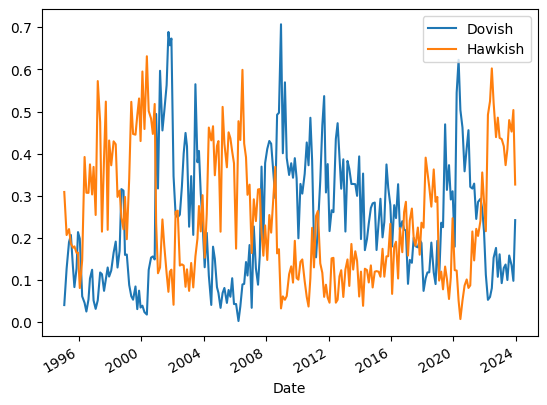

In [ ]:
sentences_split.groupby("Date")[["Dovish",	"Hawkish"]].mean().plot()